<a href="https://colab.research.google.com/github/Dmitri9149/Transformer_From_Scratch/blob/main/Final_Transformer_MXNet_v6_25600_64_16_16_10_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install d2l==0.14.4


     |███████████████████████████████▌| 834.1MB 1.4MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x66142000 @  0x7ff8371ed615 0x591f47 0x4cc229 0x4cc38b 0x50a51c 0x50c1f4 0x507f24 0x509c50 0x50a64d 0x50c1f4 0x507f24 0x509c50 0x50a64d 0x50cfd6 0x58e793 0x50c467 0x58e793 0x50c467 0x58e793 0x50c467 0x58e793 0x50c467 0x509918 0x50a64d 0x50c1f4 0x507f24 0x509c50 0x50a64d 0x50c1f4 0x509918 0x50a64d
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 61kB 4.6MB/s 


In [ ]:
### !pip install ipython-autotime

### %load_ext autotime

In [ ]:
import math
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
from mxnet import np, npx, init, gluon, autograd
import collections
import os
import time
npx.set_np()
from mxnet import autograd, np, npx


The code for Transformer from scratch is collected here. The code is mostly from  http://d2l.ai/chapter_attention-mechanisms/transformer.html . I did many comments to the code at most difficult points. I hope my additional code and comments will help in better understanding of the Transformer.   
This is the original article for the Transformer : 
Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., … Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems (pp. 5998–6008). 

The future work:  
1. To learn the Transformer on big data set.
2. Transation from (to)  English to Finnish language.
3. Modify the architecture of the Transformer. 
4. Better tokenization and preprocessing.




### Attention Mechanism


#### Masked softmax

This is importand auxiliary function.
""" The masked softmax takes a 3-dimensional input and enables us to filter out some elements by specifying a valid length for the last dimension.... As a result, any value outside the valid length will be masked as  0.""" (citation from d2l.ai).  
The notion of valid length come from the need to add special <pad> token if our sentence is shorter than length we use for all sentencies in batches. The <pad> tokens will not participate in prediction. 

My comments are started with ### , 
the comments with one # are from the original d2l.ai code.

Some functions for plotting and downloading of specific files from specific places are still taken from the d2l.ai library on GitHub : https://github.com/d2l-ai/d2l-en/blob/master/d2l/mxnet.py  But the biggest par of the code is collected here (and commented).

In [ ]:
### from d2l.ai
def masked_softmax(X, valid_len):
    """Perform softmax by filtering out some elements."""
    # X: 3-D tensor, valid_len: 1-D or 2-D tensor

### why 3-D tensor ?
### first dimention; we will quantify samples within batch,  
### so, the first dimention determines the number of samples in the batch
###
### second dimention; we will quantify queries, 
### we may have several queries,   
### the second dimention determines the number of queries
###
### we may set up the valid lengths same for every sample in the 
### batch, i.e 1-D valid-lengh with size (batch_size, )
### the same means : independent of the queries
### On the contarry: we may set up  valid lengths individually for every 
### sample in a batch and for every query,  
### in this case it will be 2-D valid length 
### with size (batch size, number of queries)
###
### Third parameter will correspond to the number of key/value pairs
###
### We may need the valid_length when: 1. we <pad> the end of a sentence: it is too 
### short, shorter than num_steps ; 2. when we use the valid_lenght in decoder 
### via training, and every word in target sentence is used as query: the query 
### can (or may ?) see the all words to the left, but not to the right (see the 
### encoder decoder code below). To handle the case we use valid_length too. 
###
    if valid_len is None:
        return npx.softmax(X)
    else:
        shape = X.shape
        if valid_len.ndim == 1:
            valid_len = valid_len.repeat(shape[1], axis=0)
        else:
            valid_len = valid_len.reshape(-1)
        # Fill masked elements with a large negative, whose exp is 0
        X = npx.sequence_mask(X.reshape(-1, shape[-1]), valid_len, True,
                              axis=1, value=-1e6)
        return npx.softmax(X).reshape(shape)

In [ ]:
### from d2l.ai
masked_softmax(np.random.uniform(size=(2, 2, 4)), np.array([2, 3]))

### 2 - number of samples in the batch
### 2 - we make deal with 2 queries
### 4 - four key/value pairs

### for the first sample in our batch , from 4 pairs we will take 
### into account only results from first 2 pairs, the rest will be multiplied by 0,  
### because that pairs correspond to <pad> tokens
### for the second sample (4 key/value pairs) we will take into account 
### only results for first 3 key/value pairs (the rest will masked with 0, 
### because the rest pairs correspond to <pad> tokens)
### this is the meaning of np.array([2,3]) as valid length
### the velid length is not dependent from queries in this case

array([[[0.488994  , 0.511006  , 0.        , 0.        ],
        [0.4365484 , 0.56345165, 0.        , 0.        ]],

       [[0.288171  , 0.3519408 , 0.3598882 , 0.        ],
        [0.29034296, 0.25239873, 0.45725837, 0.        ]]])

In [ ]:
### from d2l.ai
npx.batch_dot(np.ones((2, 1, 3)), np.ones((2, 3, 2)))

array([[[3., 3.]],

       [[3., 3.]]])

In [ ]:
### one more example with 1-D valid length
valid_length = np.array([2,3])
### the shape is (2,) : one dimentional length
print('valid_length shape= ', valid_length.shape)
masked_softmax(np.random.uniform (size =(2, 3, 5)), valid_length )

valid_length shape=  (2,)


array([[[0.6661908 , 0.33380923, 0.        , 0.        , 0.        ],
        [0.5703486 , 0.42965135, 0.        , 0.        , 0.        ],
        [0.52236456, 0.47763544, 0.        , 0.        , 0.        ]],

       [[0.4367729 , 0.2330982 , 0.33012888, 0.        , 0.        ],
        [0.3810022 , 0.20134084, 0.41765702, 0.        , 0.        ],
        [0.26511037, 0.36712292, 0.36776674, 0.        , 0.        ]]])

In [ ]:
### if we declare 2-D  valid_length
valid_length = np.array([[3, 5, 4], [2,4, 1], [1,4, 3],[1,2,3]])
print('valid_length shape= ', valid_length.shape)
masked_softmax(np.random.uniform(size = (4, 3, 5)), valid_length) 

### Let us consider the first sample in our batch 

###        [[0.21225105, 0.31475353, 0.4729953 , 0.        , 0.        ,
###         0.        ],
###        [0.19417836, 0.20596693, 0.16711308, 0.15453914, 0.27820238,
###         0.        ],
###        [0.2753876 , 0.21671425, 0.30811197, 0.19978616, 0.        ,
###         0.        ]],


### from third dimention in np.random.uniform(size = (4, 3, 5)) we may see it correspond to 
### 5 key/value pairs (that is why the length of the lines is 5)
### second dimention in np.random.uniform(size = (4, 3, 5)) means the results are obtained from 
### 3 queries, that is why there are 3 lines corresponding to every batch
###
### Below we may see there are 4 groups, because the first dimention, the 
### number of samples, is 4 (batch size)
###
### np.array([[3, 5, 4], [2,4, 1], [1,4, 3],[1,2,3]])  
### is 2-D array (of size 4 * 3 in our case))
### 4 is batch size, 3 is number of queries : we have 4 groups with 3 lines in each; 
### the [3,5,4] subarray correspond to the first sample in the batch,  
### in the first group : the first line has first 3 non zero elements, 
### the second line 5 first non zero and third line 4 first non zero elements. 


valid_length shape=  (4, 3)


array([[[0.4133883 , 0.37343267, 0.21317907, 0.        , 0.        ],
        [0.19114935, 0.12327141, 0.18280292, 0.27470675, 0.22806959],
        [0.28482115, 0.18790206, 0.25587142, 0.27140537, 0.        ]],

       [[0.3571165 , 0.6428835 , 0.        , 0.        , 0.        ],
        [0.33235466, 0.21550561, 0.19182019, 0.2603195 , 0.        ],
        [1.        , 0.        , 0.        , 0.        , 0.        ]],

       [[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.23461454, 0.19674575, 0.31332123, 0.25531843, 0.        ],
        [0.18806307, 0.46701482, 0.34492216, 0.        , 0.        ]],

       [[1.        , 0.        , 0.        , 0.        , 0.        ],
        [0.42741585, 0.5725841 , 0.        , 0.        , 0.        ],
        [0.23219864, 0.34646067, 0.42134076, 0.        , 0.        ]]])

### Dot product attention

#### Why we need it, how it is calculated



We have query with dimension `d`.
We have #kv_pairs:  key/value pairs. Every key and value are vectors of dimension `d`. We pass the query trought the 'grid' with the leng of #kv_pairs and get #kv_pairs of scores. How it works within the pass: we make dot product of query with every of #kv_pairs keys in the 'grid' and get a #kv_pairs scores. We also normilize the scores by dividing on $\sqrt{d}$.    
If we have batch with size batch_size and number of queries = #queries, we will get tensor of scores of size (batch_size, #queries, #kv_pairs). 
In this way we receive the attention_weights tensor.
We also have tensor 'value' of values of size (batch_size, #kv_pairs, dim_v). 
Finally, using npx.batch_dot(attention_weights, value) we will get tensor of size (batch_size, #queries, dim_v) which corresponf of the 'passing' our queries throught the 'grid' of key/value pairs: for every query, for every sample in the batch we will get the transformed vector of size dim_v.  


In [ ]:
### from d2l.ai book
class DotProductAttention(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `query`: (`batch_size`, #queries, `d`)
    # `key`: (`batch_size`, #kv_pairs, `d`)
    # `value`: (`batch_size`, #kv_pairs, `dim_v`)
    # `valid_len`: either (`batch_size`, ) or (`batch_size`, xx)
    def forward(self, query, key, value, valid_len=None):
        d = query.shape[-1]
        # Set transpose_b=True to swap the last two dimensions of key
        scores = npx.batch_dot(query, key, transpose_b=True) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return npx.batch_dot(attention_weights, value)


In [ ]:
if False:
   ### the code from d2l.ai
  atten = DotProductAttention(dropout=0.5)
  atten.initialize()
  ### batch size of 2, #kv_pairs = 10, every key is vector of size 2 with 
  ### ones : (1.,1.)
  keys = np.ones((2, 10, 2))
  ### we start with vector which keep float numbers from 0 to 39; 
  ### reshape it to tensor which model one sample batch with 10 key/value pairs and 
  ### dimension of values dim_v = 4; finally we repeat the construction to get 2 
  ### similar samples (batch with 2 samples).
  values = np.arange(40).reshape(1, 10, 4).repeat(2, axis=0)
  atten(np.ones((2, 1, 2)), keys, values, np.array([2, 6]))


In [ ]:
if False:
  atten = DotProductAttention(dropout=0.5)
  atten.initialize()
  keys = np.ones((3,10,5)) # keys in batch of size 3; for every line in batch we have 
  ### 10 keys/values pairs ; where every key is  5 dimentional vector (and value will be 7 dimentional vector); 
  ### each key is forming pair with value, there are 10 such pairs

  values = np.arange(70).reshape(1,10,7).repeat(3, axis =0) # values in batch of 
  ### size 3 ; 10 values with 7 dimentional vector each;
  ### in our batch the 3 samples are identical by construction

  queries = np.ones((3,4,5)) # quiries in batch of size 3, there are 4 queries, 
  ### where every query is vector of size 5 (same size as for key)

  atten(queries, keys, values, np.array([3, 8, 6]))  # values in batch of size 3 ; 
  ### 4 quiry per every sample in batch where every query is vector of size 5 

  ### the valid_len is 1-D
  ### for the 3 samples the valid_length have size 3 , 8 , 6 ; 
  ### size 3 for first sample , ....., ..... size 6 for the last sample

  ### the outputs are: 
  ### for every entry in the batch (for every of the 3 samples)
  ### for every of 4 queries
  ### total : 3*4 = 12 final values: vectors of size 7 
  ### the values are different for different samples in the batch , 
  ### because we used different valid length, 
  ### but for every sample group in the batch (same sample, different queries), 
  ### all 4 final values are the same: 
  ### even we use 4 queries, all the quiries are equal in our case 

### Multihead Attention

""" The *multi-head attention* layer consists of $h$ parallel self-attention layers, each one is called a *head*. For each head, before feeding into the attention layer, we project the queries, keys, and values with three dense layers with hidden sizes $p_q$, $p_k$, and $p_v$, respectively. The outputs of these $h$ attention heads are concatenated and then processed by a final dense layer.


![Multi-head attention](../img/multi-head-attention.svg)


Assume that the dimension for a query, a key, and a value are $d_q$, $d_k$, and $d_v$, respectively. Then, for each head $i=1,\ldots, h$, we can train learnable parameters
$\mathbf W_q^{(i)}\in\mathbb R^{p_q\times d_q}$,
$\mathbf W_k^{(i)}\in\mathbb R^{p_k\times d_k}$,
and $\mathbf W_v^{(i)}\in\mathbb R^{p_v\times d_v}$. Therefore, the output for each head is

$$\mathbf o^{(i)} = \mathrm{attention}(\mathbf W_q^{(i)}\mathbf q, \mathbf W_k^{(i)}\mathbf k,\mathbf W_v^{(i)}\mathbf v),$$

where $\textrm{attention}$ can be any attention layer, such as the `DotProductAttention` and `MLPAttention` as we introduced in :numref:`sec_attention`.



After that, the output with length $p_v$ from each of the $h$ attention heads are concatenated to be an output of length $h p_v$, which is then passed the final dense layer with $d_o$ hidden units. The weights of this dense layer can be denoted by $\mathbf W_o\in\mathbb R^{d_o\times h p_v}$. As a result, the multi-head attention output will be

$$\mathbf o = \mathbf W_o \begin{bmatrix}\mathbf o^{(1)}\\\vdots\\\mathbf o^{(h)}\end{bmatrix}.$$


Now we can implement the multi-head attention. Assume that the multi-head attention contain the number heads `num_heads` $=h$, the hidden size `num_hiddens` $=p_q=p_k=p_v$ are the same for the query,  key, and value dense layers. In addition, since the multi-head attention keeps the same dimensionality between its input and its output, we have the output feature size $d_o =$ `num_hiddens` as well. """ (citation from d2l.ai book). 


There are some problems in the d2l.ai text, there is stated :   
$p_q$ = $p_k$ = $p_v$ = num_hiddens,  
and 
$d_o =$ `num_hiddens` as well.  
So, we have $W_o$ transformation from input of size (num_heads * num_hiddens) to output of size (num_hiddens). If h > 1, the input size and output size can not be equal. But in the PyTorch code in the d2l.ai we have:  
self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias) 
with equal input and output. It is hidden in the d2l.ai 
MXNet code: self.W_o = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False), because in the 
case of Gluon Dense layer we state only output dimension (num_hiddens in the case). The input dimension is not stated. 

There is also assumed in the code below (from d2l.ai book), the num_hiddens is multiple of num_heads. No assumptions about it in the main text of the book. But in the d2l.ai code the assumption is used.

The ony interpretation to the code below I may give now:  
$p_v$ * num_heads=num_hiddens  (same for  $p_q$ = $p_k$ = $p_v$),  
but not $p_v$=num_hiddens.  
I will interpret the code with the assumption.  



In [ ]:
### from d2l.ai
class MultiHeadAttention(nn.Block):
    def __init__(self, num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
### here, as I understand, the num_hiddens = num_heads * p_v 
### where p_v (see the text above) is the dimension of the vector 
### to which a query is transformed by single head,
### the size of p_v is to be (num_hidden/num_heads)
### it explains what the code below do
        self.W_q = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
        self.W_k = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
        self.W_v = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)
### if every head transform query of size `dim` = num_hiddens to 
### p_v = p_q = p_k = (num_hidden/num_heads), when we 
### concatenate num_heads of such queries, we will get 
### vector of size num_hidden again; 
### it explains the input / output dimensions for W_o : 
### input and output have same dimension = num_hiddens
        self.W_o = nn.Dense(num_hiddens, use_bias=use_bias, flatten=False)


### every query generate num_heads outputs , which we cancatenate in 
### one vector of dimention num_hiddens : so the output of every query is 
### of size num_heads / num_hiddens;
### to apply self-attention we de-cancatenate the combined output 
### to hum_heads of separate outputs from every query 
### with size (num_hiddens / num_heads), and 
### simultaneously recombine them in single batch (with size num_heads),
### which increase the total batch size to (batch_size * num_heads)
### We have to correct the valid_length to take into account 
### the num_heads query transformtions are combined now in single batch.
### After application of self_attention, we make the reverse operation: 
### locate the batch samples which correspond to the outputs of the same query 
### in different heads, and concatenate them again in one combined output.
### The number of batches decrease and the length of output increase by the 
### same factor num_heads.
### These are the roles of transpose_qkv , transpose_output functions below:
    def forward(self, query, key, value, valid_len):
        # For self-attention, `query`, `key`, and `value` shape:
        # (`batch_size`, `seq_len`, `dim`), where `seq_len` is the length of
        # input sequence. `valid_len` shape is either (`batch_size`, ) or
        # (`batch_size`, `seq_len`).

        # Project and transpose `query`, `key`, and `value` from
        # (`batch_size`, `seq_len`, `num_hiddens`) to
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        query = transpose_qkv(self.W_q(query), self.num_heads)
        key = transpose_qkv(self.W_k(key), self.num_heads)
        value = transpose_qkv(self.W_v(value), self.num_heads)

        if valid_len is not None:
            # Copy `valid_len` by `num_heads` times
            if valid_len.ndim == 1:
                valid_len = np.tile(valid_len, self.num_heads)
            else:
                valid_len = np.tile(valid_len, (self.num_heads, 1))

        # For self-attention, `output` shape:
        # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
        output = self.attention(query, key, value, valid_len)

        # `output_concat` shape: (`batch_size`, `seq_len`, `num_hiddens`)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)


In [ ]:
### from d2l.ai
def transpose_qkv(X, num_heads):
    # Input `X` shape: (`batch_size`, `seq_len`, `num_hiddens`).
    # Output `X` shape:
    # (`batch_size`, `seq_len`, `num_heads`, `num_hiddens` / `num_heads`)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # `X` shape:
    # (`batch_size`, `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    X = X.transpose(0, 2, 1, 3)

    # `output` shape:
    # (`batch_size` * `num_heads`, `seq_len`, `num_hiddens` / `num_heads`)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    return output


### from d2l.ai
def transpose_output(X, num_heads):
    # A reversed version of `transpose_qkv`
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.transpose(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


In [ ]:
if False:
  ### from d2l.ai
  ### num_hiddens = 100, num_heads=10
  cell = MultiHeadAttention(100, 10, 0.5)
  cell.initialize()
  X = np.ones((2, 4, 5))
  valid_len = np.array([2, 3])
  cell(X, X, X, valid_len).shape


In [ ]:
if False:
  ### it correspond to scenario size of embedding is 512 ; num_heads = 8 ; 
  ### num_hiddens = 512
  cell = MultiHeadAttention(512, 8, 0.5)
  cell.initialize()
  # num of batches is 3 ; seq_len is 20 ; size of embedding is 512
  X = np.ones((3, 20, 512))
  valid_len = np.array([15,17,12])
  cell(X, X, X, valid_len).shape

### Position-wise encoding

Two 1 * 1 convolutional layers are applied. Extract 
position independent features of word representations (in the same way the convolution layers are applied in image recognition networks).  
""" Similar to the multi-head attention, the position-wise feed-forward network will only change the last dimension size of the input—the feature dimension. In addition, if two items in the input sequence are identical, the according outputs will be identical as well. """ (citation from d2l.ai)

In [ ]:
### from d2l.ai
class PositionWiseFFN(nn.Block):
    def __init__(self, ffn_num_hiddens, pw_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Dense(ffn_num_hiddens, flatten=False,
                               activation='relu')
        self.dense2 = nn.Dense(pw_num_outputs, flatten=False)

    def forward(self, X):
        return self.dense2(self.dense1(X))


In [ ]:
if False:
  ffn = PositionWiseFFN(4, 8)
  ffn.initialize()
  ffn(np.ones((2, 3, 4)))[0]


### Add and Norm
""" we add a layer that contains a residual structure and a layer normalization after both the multi-head attention layer and the position-wise FFN network. Layer normalization is similar to batch normalization ........ One difference is that the mean and variances for the layer normalization are calculated along the last dimension, e.g X.mean(axis=-1) instead of the first batch dimension, e.g., X.mean(axis=0). Layer normalization prevents the range of values in the layers from changing too much, which allows faster training and better generalization ability. """ (citation from d2l.ai)

In [ ]:
if False:
  ### from d2l.ai
  layer = nn.LayerNorm()
  layer.initialize()
  batch = nn.BatchNorm()
  batch.initialize()
  X = np.array([[1, 2], [2, 3]])
  # Compute mean and variance from `X` in the training mode
  with autograd.record():
      print('layer norm:', layer(X), '\nbatch norm:', batch(X))


"""AddNorm accepts two inputs X and Y. We can deem X as the original input in the residual network, and Y as the outputs from either the multi-head attention layer or the position-wise FFN network. In addition, we apply dropout on Y for regularization.""" citation from d2l.ai

In [ ]:
### from d2l.ai
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm()

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)


In [ ]:
if False:
  ### d2l.ai
  add_norm = AddNorm(0.5)
  add_norm.initialize()
  add_norm(np.ones((2, 3, 4)), np.ones((2, 3, 4))).shape


### Positional Encoding

In [ ]:
### I used the code as alternative to the original positional encoding; 
### just encode position of words (tokens) in sentence ,
### it changes the results , but the results are quite well. 
if False:
      ### from d2l.ai
      class PositionalEncoding(nn.Block):
          def __init__(self, num_hiddens, dropout, max_len=100):
              super(PositionalEncoding, self).__init__()
              self.dropout = nn.Dropout(dropout)
              # Create a long enough `P`
      ### max_len correspond to sequence length ; 
      ### num_hiddens correspond to embedding size
      ###         
              self.P = np.zeros((1, max_len, num_hiddens))
      ###        X = np.arange(0, max_len).reshape(-1, 1) / np.power(
      ###            10000, np.arange(0, num_hiddens, 2) / num_hiddens)
      ###        self.P[:, :, 0::2] = np.sin(X)
      ###        self.P[:, :, 1::2] = np.cos(X)


      ###################### my code be carefull !!!!!
              X = np.arange(0, max_len).reshape(-1, 1) / max_len
      ###            10000, np.arange(0, num_hiddens, 2) / num_hiddens)
              self.P[:, :, 0::1] = np.sin(X)
      ###        self.P[:, :, 1::2] = np.cos(X)
      ################################


          def forward(self, X):
              X = X + self.P[:, :X.shape[1], :].as_in_ctx(X.ctx)
              return self.dropout(X)


In [ ]:
### from d2l.ai
class PositionalEncoding(nn.Block):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
### max_len correspond to sequence length ; 
### num_hiddens correspond to embedding size
        self.P = np.zeros((1, max_len, num_hiddens))
        X = np.arange(0, max_len).reshape(-1, 1) / np.power(
            10000, np.arange(0, num_hiddens, 2) / num_hiddens)
        self.P[:, :, 0::2] = np.sin(X)
        self.P[:, :, 1::2] = np.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].as_in_ctx(X.ctx)
        return self.dropout(X)

In [ ]:
if False:
  ### from d2l.ai
  ### num_hiddens = 20 , dropout = 0
  pe = PositionalEncoding(20, 0)
  pe.initialize()
  ### we assume batch_size = 1; max_length = 100 correspond to tokens (here words) in our line;
  ### num_hiddens = 20 (embedding size)
  ### 
  Y = pe(np.zeros((1, 100, 20)))
  ### dim correspond to coordinate in embedding vector of out tokens (words)
  d2l.plot(np.arange(100), Y[0, :, 4:8].T, figsize=(6, 2.5),
          legend=["dim %d" % p for p in [4, 5, 6, 7]])


### Encoder

"""Armed with all the essential components of Transformer, let us first build a Transformer encoder block. This encoder contains a multi-head attention layer, a position-wise feed-forward network, and two “add and norm” connection blocks. As shown in the code, for both of the attention model and the positional FFN model in the EncoderBlock, their outputs’ dimension are equal to the num_hiddens. This is due to the nature of the residual block, as we need to add these outputs back to the original value during “add and norm”. """ (citation from d2l.ai)

In [ ]:
### from d2l.ai
### this block will not change the input shape
class EncoderBlock(nn.Block):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(num_hiddens, num_heads, dropout,
                                            use_bias)
        self.addnorm1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(dropout)

    def forward(self, X, valid_len):
### we sum the original input to the attention block and the output from the  
### block + we normilize the result using AddNorm 

        Y = self.addnorm1(X, self.attention(X, X, X, valid_len))
        return self.addnorm2(Y, self.ffn(Y))


""" Now it comes to the implementation of the entire Transformer encoder. With the Transformer encoder, $n$ blocks of `EncoderBlock` stack up one after another. Because of the residual connection, the embedding layer size $d$ is same as the Transformer block output size. Also note that we multiply the embedding output by $\sqrt{d}$ to prevent its values from being too small. """ (citation from d2l.ai)

In [ ]:
### from d2l.ai
class Encoder(nn.Block):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [ ]:
### from d2l.ai
class TransformerEncoder(Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for _ in range(num_layers):
            self.blks.add(
                EncoderBlock(num_hiddens, ffn_num_hiddens, num_heads, dropout,
                             use_bias))
### the order of steps:
### firstly we apply Positinal Encoding to initial word vectors
### FROM HERE: Then several times do:
### apply Multihead Attention
### apply Add Norm
### apply PositionWise transformation
### apply Add Norm
### and again... Go To  FROM HERE
    def forward(self, X, valid_len, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_len)
        return X


### Decoder

""" During training, the output for the $t$-query could observe all the previous key-value pairs. It results in an different behavior from prediction. Thus, during prediction we can eliminate the unnecessary information by specifying the valid length to be $t$ for the $t^\textrm{th}$ query. """
(citation from d2l.ai)

In [ ]:
### from d2l.ai
class DecoderBlock(nn.Block):
    # `i` means it is the i-th block in the decoder
### the i will be initialized from the TransformerDecoder block 
### the block will be used in TransformerDecoder in stack , 
### several blocks will be aranged in sequence, output from 
### one block will be input to the next blosk
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
### in the block we will aplly (MultiHeadAttention + AddNorm) 
### and again (MultiHeadAttention + AddNorm)  ; 
### then we will apply PositionWiseFFN
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(dropout)

    def forward(self, X, state):

### we use state [0] and state[1] to keep output from TransformerEncoder : 
### enc_outputs and enc_valid_length; 
### which correspond to sentences we are translating (sentences in language FROM 
### which we translate); 
### the state [0] and state [1] are received from TransformerDecoder 
### enclosing block as shared parameter;      
        enc_outputs, enc_valid_len = state[0], state[1]
        # `state[2][i]` contains the past queries for this block
### in the first block (i = 1) , at this place in code, 
### the queries = None, see the code in TransformetEncoder : 
###
###    def init_state(self, enc_outputs, enc_valid_len, *args):
###        return [enc_outputs, enc_valid_len, [None]*self.num_layers]
###
### TransformerEncoder is initialized from EncoderDecoder
### using the 'init_state' function (see above) , as 
### we can see, the fird element in array is None for self.layers;
### the 'init_state'  determines the 'state' in TransformerEncoder, 
### in the code above we use state[0] and state[1] to determine 
### 'enc_outputs', 'enc_valid_len' in this block 
        if state[2][self.i] is None:          
            key_values = X 
        else:
### queries are processed and concatenated and used as new 
### grid of key/value pairs           
            key_values = np.concatenate((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if autograd.is_training():
### here are are in training mode
### below in 'attention' function we will use X as queries, 
### X correspond to all words in the target sentence within training; 
### seq_len correspond to the length of the whole target sentence; 
### we will use seq_len queries, for every sample in the batch;
### for us important the following: 
### first query from the sentence has to be constrained 
### to first key_value pair; second: to the first two key_value pairs, 
### etc...
### that is why the valid_len is generated in the way:           
            batch_size, seq_len, _ = X.shape
            # Shape: (batch_size, seq_len), the values in the j-th column
            # are j+1
### while training we take into account the result of passing a query 
### in target sentence throught the 'grid' of key/value pairs to the 
### left of the query ; 
### every query in the target sequence has its own valid_len and 
### the valid_len correspond to the position of a query in the 
### sentence
            valid_len = np.tile(np.arange(1, seq_len + 1, ctx=X.ctx),
                                (batch_size, 1))

        else:
            valid_len = None

### the attention mechanism is used on key_values corresponding 
### to the target sentence key_values (then AddNorm is applied)
        X2 = self.attention1(X, key_values, key_values, valid_len)
        Y = self.addnorm1(X, X2)
### the attention mechanism is used on TransformerEncoder outputs 
### key_values as the 'grid' (then AddNorm is applied);
### the key/values are the learned pairs 
### which are originated from the source sentence
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_len)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state


In [ ]:
### from d2l.ai
class Decoder(nn.Block):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [ ]:
### from d2l.ai
class TransformerDecoder(Decoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)

### sequential application of several DecoderBlock's         
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add(
                DecoderBlock(num_hiddens, ffn_num_hiddens, num_heads,
                             dropout, i))
        self.dense = nn.Dense(vocab_size, flatten=False)


    def init_state(self, enc_outputs, env_valid_len, *args):
       return [enc_outputs, env_valid_len, [None]*self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X, state = blk(X, state)
        return self.dense(X), state


In [ ]:
### from d2l.ai
### this block couples together TransformerEncoder and TransformerDecoder
### 
class EncoderDecoder(nn.Block):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
### the enc_outputs are moved to decoder from encoder; 
### the coupling happens in this point of code
        enc_outputs = self.encoder(enc_X, *args)
### initial decoder state: dec_state is calculated using the dec_outputs 
### and used as 'state' in TransformerDecoder         
        dec_state = self.decoder.init_state(enc_outputs, *args)
### use initial state + input dec_X to the decoder   to calculate 
### the decoder output
        return self.decoder(dec_X, dec_state)

### Training

In [ ]:
### from d2l.ai
### because of the padding (and valid_length) we have to filter out some entries
class MaskedSoftmaxCELoss(gluon.loss.SoftmaxCELoss):
    # `pred` shape: (`batch_size`, `seq_len`, `vocab_size`)
    # `label` shape: (`batch_size`, `seq_len`)
    # `valid_len` shape: (`batch_size`, )
    def forward(self, pred, label, valid_len):
        # weights shape: (batch_size, seq_len, 1)
        weights = np.expand_dims(np.ones_like(label), axis=-1)
        weights = npx.sequence_mask(weights, valid_len, True, axis=1)
        return super(MaskedSoftmaxCELoss, self).forward(pred, label, weights)

In [ ]:
if False:
  ### from d2l.ai 
  loss = MaskedSoftmaxCELoss()
  loss(np.ones((3, 4, 10)), np.ones((3, 4)), np.array([4, 2, 0]))

In [ ]:
### from d2l.ai
### prevents too high gradients 
def grad_clipping(model, theta):  
    """Clip the gradient."""
    if isinstance(model, gluon.Block):
        params = [p.data() for p in model.collect_params().values()]
    else:
        params = model.params
    norm = math.sqrt(sum((p.grad ** 2).sum() for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [ ]:
### from d2l.ai
### accumulate results in one array, auxiliary function
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
### from d2l.ai
def train_s2s_ch9(model, data_iter, lr, num_epochs, device):
    model.initialize(init.Xavier(), force_reinit=True, ctx=device)
    trainer = gluon.Trainer(model.collect_params(),
                            'adam', {'learning_rate': lr})
    loss = MaskedSoftmaxCELoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], ylim=[0, 1.00])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        
### use data_iter from load_data_nmt to get X and Y which include: 
### the source and target 
### sentence representations + X_vlen and Y_vlen : the valid lenghts of 
### the sentencies        
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.as_in_ctx(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            with autograd.record():
                Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
                l = loss(Y_hat, Y_label, Y_vlen)
            l.backward()
            grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            trainer.step(num_tokens)
            metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

### Reading and Processing the Text

In [ ]:
### from d2l.ai
def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

""" ... a dataset that contains a set of English sentences with the corresponding French translations. As can be seen that each line contains an English sentence with its French translation, which are separated by a TAB.""" (citation from d2l.ai)

In [ ]:
### d2l.ai
### the data for the translation are prepared by the d2l.ai project (book)

d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')


def read_data_nmt():
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

In [ ]:
raw_text = read_data_nmt()
print(raw_text[0:106])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !


In [ ]:
### from d2l.ai
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

In [ ]:
### from d2l.ai
text = preprocess_nmt(raw_text)
print(text[0:95])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who?	qui ?
wow !	ça alors !
fire !	au feu !


In [ ]:
### from d2l.ai
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target


In [ ]:
### from d2l.ai
source, target = tokenize_nmt(text)
source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['run', '!']],
 [['va', '!'], ['salut', '!'], ['cours', '!']])

#### Histogram of the number of tokens per sentence

There are mostly 5 token sentencies, num of tokens is 
usually less than 10..15.

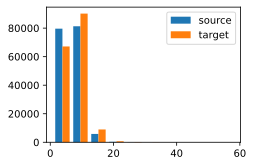

In [ ]:
### from d2l.ai

d2l.set_figsize()
d2l.plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
d2l.plt.legend(loc='upper right');

### Vocabulary

In [ ]:
### from d2l.ai
def count_corpus(tokens): 
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [ ]:
### from d2l.ai
class Vocab: 
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = [] 
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[0])
        self.token_freqs.sort(key=lambda x: x[1], reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [token for token, freq in self.token_freqs
                        if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

In [ ]:
### from d2l.ai
src_vocab = Vocab(source, min_freq=3,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

9140

### Loading the dataset

In [ ]:
### from d2l.ai
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]  # Trim
    return line + [padding_token] * (num_steps - len(line))  # Pad

### the <pad> is represented by number 1 in Vocabuary

In [ ]:
### from d2l.ai
truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [ ]:
### from d2l.ai
def build_array(lines, vocab, num_steps, is_source):
    lines = [vocab[l] for l in lines]
    if not is_source:
        lines = [[vocab['<bos>']] + l + [vocab['<eos>']] for l in lines]
    array = np.array([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).sum(axis=1)
    return array, valid_len

In [ ]:
### from d2l.ai
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a Gluon data iterator."""
    dataset = gluon.data.ArrayDataset(*data_arrays)
    return gluon.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
### from d2l.ai
### quite importand function to construct dataset for training (data_iter) 
### from original data
def load_data_nmt(batch_size, num_steps, num_examples=25600):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = Vocab(source, min_freq=3,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = Vocab(target, min_freq=3,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array(
        source, src_vocab, num_steps, True)
    tgt_array, tgt_valid_len = build_array(
        target, tgt_vocab, num_steps, False)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = load_array(data_arrays, batch_size)
    return src_vocab, tgt_vocab, data_iter

In [ ]:
### from d2l.ai
def try_gpu(i=0): 
    """Return gpu(i) if exists, otherwise return cpu()."""
    return npx.gpu(i) if npx.num_gpus() >= i + 1 else npx.cpu()

### Model: training and prediction 

loss 0.023, 4408.0 tokens/sec on gpu(0)
12994.927897453308


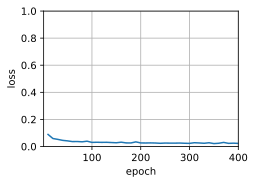

In [ ]:
### the code from d2l.ai

### estimate the execution time for the cell in seconds
start = time.time()


num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.0, 64, 16
lr, num_epochs, device = 0.001, 400, try_gpu()
ffn_num_hiddens, num_heads = 64, 4  ### num_hiddens is to be a multiple of num_heads !!

src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size, num_steps,25600)

encoder = TransformerEncoder(
    len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_layers,
    dropout)
decoder = TransformerDecoder(
    len(src_vocab), num_hiddens, ffn_num_hiddens, num_heads, num_layers,
    dropout)
model = EncoderDecoder(encoder, decoder)
train_s2s_ch9(model, train_iter, lr, num_epochs, device)

### estimate the execution time for the cell
end = time.time()
print(end - start)


In [ ]:
### from d2l.ai
def predict_s2s_ch9(model, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device):
    src_tokens = src_vocab[src_sentence.lower().split(' ')]
    enc_valid_len = np.array([len(src_tokens)], ctx=device)
    src_tokens = truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    enc_X = np.array(src_tokens, ctx=device)
    # Add the  batch size dimension
    enc_outputs = model.encoder(np.expand_dims(enc_X, axis=0),
                                enc_valid_len)
    dec_state = model.decoder.init_state(enc_outputs, enc_valid_len)
    dec_X = np.expand_dims(np.array([tgt_vocab['<bos>']], ctx=device), axis=0)
    predict_tokens = []
    for _ in range(num_steps):
        Y, dec_state = model.decoder(dec_X, dec_state)
        # The token with highest score is used as the next time step input
        dec_X = Y.argmax(axis=2)
        py = dec_X.squeeze(axis=0).astype('int32').item()
        if py == tgt_vocab['<eos>']:
            break
        predict_tokens.append(py)
    return ' '.join(tgt_vocab.to_tokens(predict_tokens))

In [ ]:
for sentence in ['Go .', 'Wow !', "I'm OK .", 'I won !', 
                 'Let it be !', 'How are you ?', 'How old are you ?', 
                 'Cats are cats, dogs are dogs .', 'My friend lives in US .',
                 'He is fifty nine years old .', 'I like music and science .', 
                 'I love you .', 'The dog is chasing the cat .', 
                 'Somewhere on the earth .', 'Do not worry !', 
                 'Sit down, please !', 'Not at all !', 'It is very very strange .', 
                 'Take it into account .', 'The dark side of the moon .',
                 'Come on !', 'We are the champions, my friends .']:
    print(sentence + ' => ' + predict_s2s_ch9(
        model, sentence, src_vocab, tgt_vocab, num_steps, device))


Go . => va !
Wow ! => ça alors donc , alors si alors si nouveau , <unk> ! raison ! raison !
I'm OK . => je vas bien .
I won ! => j'ai gagné la vérité .
Let it be ! => laisse sois honnête au <unk> au <unk> le <unk> au <unk> le <unk> aller !
How are you ? => comment êtes-vous ?
How old are you ? => quel âge as-tu que vous éteinte ?
Cats are cats, dogs are dogs . => les chats sont des chiens sont des chiens sont des chiens sont des chiens sont des
My friend lives in US . => mon ami de l'arbre de mon <unk> .
He is fifty nine years old . => il est âgé est <unk> plein <unk> ans .
I like music and science . => j’aime pêcher .
I love you . => je t'aime du point .
The dog is chasing the cat . => le chien est le chien éteinte est le chien est le chien est le chien est
Somewhere on the earth . => <unk> sur la <unk> <unk> <unk> .
Do not worry ! => ne pas vraiment m'en éteinte ! pas faire éteinte ! pas souci !
Sit down, please ! => asseyez-vous ! <unk> rester !
Not at all ! => ne pas tout ceci n'es